In [1]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions, BenchmarkTools

In [2]:
includet("../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
domain  = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

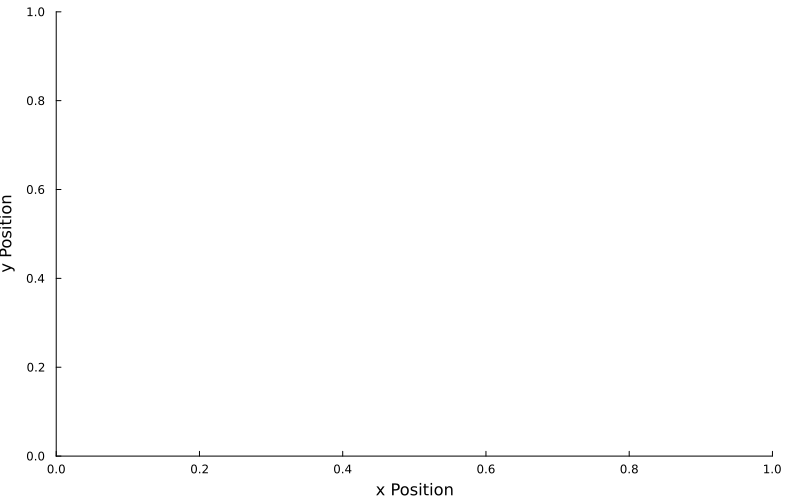

In [4]:
# Define the plot
num_points = 100

plt_grid_x1 = [domain[1][1] + i * (domain[1][2] - domain[1][1]) / num_points for j in 0:num_points, i in 0:num_points]
plt_grid_x2 = [domain[2][1] + j * (domain[2][2] - domain[2][1]) / num_points for j in 0:num_points, i in 0:num_points]

grid = range(0, stop=1, length=(num_points + 1))
plot_size = (400, 250) .* 2
plt = heatmap(xlims=domain[1], ylims=domain[2], xlabel="x Position", ylabel="y Position", color=:viridis, colorbar_title="Amplitude", size=plot_size, grid=false)

In [5]:
ops = gaussian_operators_2D(0.1, plt_grid_x1, plt_grid_x2)

Operators(var"#ϕ#38"{Float64, Matrix{Float64}, Matrix{Float64}, var"#gauss2DN#37"{var"#gauss2D#36"}}(0.1, [0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0; … ; 0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0], [0.0 0.0 … 0.0 0.0; 0.01 0.01 … 0.01 0.01; … ; 0.99 0.99 … 0.99 0.99; 1.0 1.0 … 1.0 1.0], var"#gauss2DN#37"{var"#gauss2D#36"}(var"#gauss2D#36"())), var"#Φ#40"{var"#ϕ#38"{Float64, Matrix{Float64}, Matrix{Float64}, var"#gauss2DN#37"{var"#gauss2D#36"}}}(var"#ϕ#38"{Float64, Matrix{Float64}, Matrix{Float64}, var"#gauss2DN#37"{var"#gauss2D#36"}}(0.1, [0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0; … ; 0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0], [0.0 0.0 … 0.0 0.0; 0.01 0.01 … 0.01 0.01; … ; 0.99 0.99 … 0.99 0.99; 1.0 1.0 … 1.0 1.0], var"#gauss2DN#37"{var"#gauss2D#36"}(var"#gauss2D#36"()))), var"#adjΦ#41"{Matrix{Float64}, Matrix{Float64}, var"#adjΦ#35#42"{var"#ϕ#38"{Float64, Matrix{Float64}, Matrix{Float64}, var"#gauss2DN#37"{var"#gauss2D#36"}}}}([0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0; … ; 0.0 0.01 … 0.

## Pre-certificate

 46.257385 seconds (432.28 M allocations: 19.412 GiB, 16.86% gc time, 18.25% compilation time)


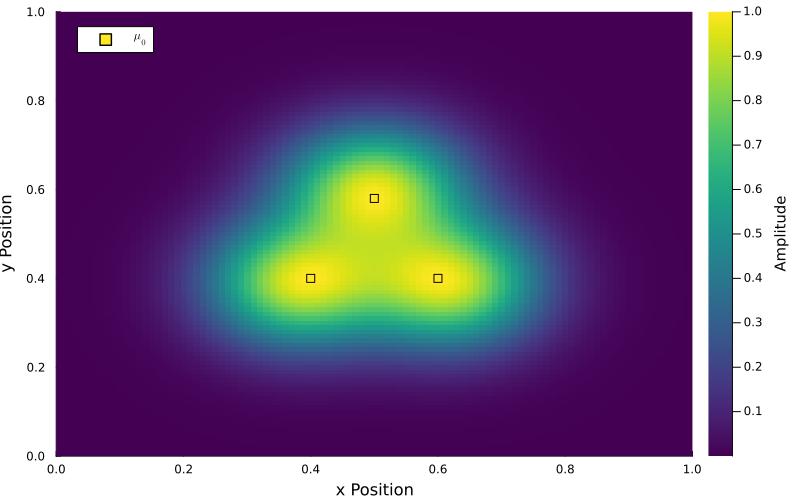

In [6]:
x0 = [[0.4, 0.5, 0.6], [0.4, 0.58, 0.4]]
a0 = [1.0, 1.0, 1.0]

μ0 = DiscreteMeasure(x0, a0)

@time ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, grid, grid, ηV, color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", marker=:square)

### SFW

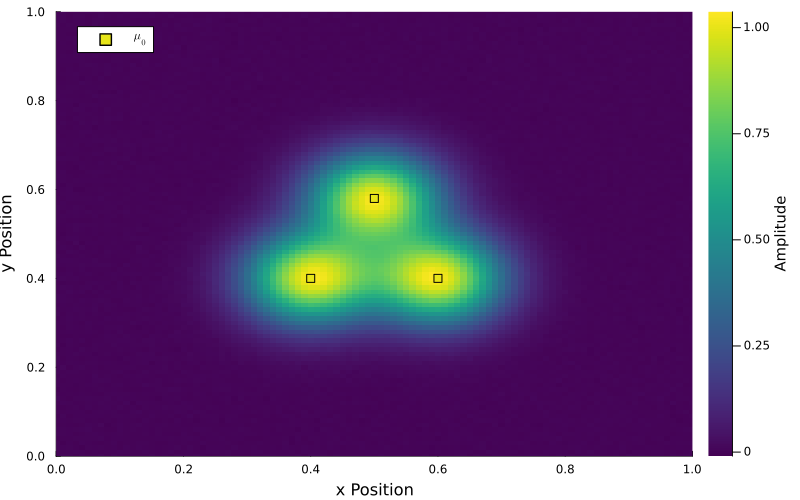

In [7]:
y0 = ops.Φ(μ0...)

function add_noise(y0, noise_level)
    sigma = noise_level * norm(y0)
    w = randn(length(y0))
    w = w / norm(w) * sigma
    y = y0 + w
    return y
end

# Add noise to the observation y = y0 + w
noise_level = 0.01
y = add_noise(y0, noise_level)

plt_obs = deepcopy(plt)

heatmap!(plt_obs, grid, grid, reshape(y, size(plt_grid_x1)), color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", marker=:square)

λ: 1000.0
  1.146928 seconds (18.08 M allocations: 827.414 MiB, 12.90% gc time)
r: 24.271661619096225
τδ: 0.25
prob.μ: DiscreteMeasure([Float64[], Float64[]], Float64[], 2, 0)

λ: 300.0
  1.501758 seconds (18.08 M allocations: 827.414 MiB, 38.26% gc time)
r: 24.271661619096225
τδ: 0.25
prob.μ: DiscreteMeasure([Float64[], Float64[]], Float64[], 2, 0)

λ: 90.0
 39.308003 seconds (317.66 M allocations: 56.013 GiB, 21.61% gc time, 0.02% compilation time)
r: 11.428479273266355
τδ: 0.25
prob.μ: DiscreteMeasure([[0.5849999999999971, 0.5049999999999999, 0.41499999999999587], [0.40499999999998615, 0.5550000000000058, 0.414999999999999]], [0.5036369426451016, 0.5115496368478545, 0.5143426743269764], 2, 3)

λ: 27.0
149.825445 seconds (1.73 G allocations: 199.840 GiB, 17.95% gc time, 1.28% compilation time)
r: 3.5735572248512617
τδ: 0.25
prob.μ: DiscreteMeasure([[0.5950000000000039, 0.500316089267634, 0.40499999999998076, 0.5950000000002486], [0.4049999999999991, 0.5749999999999995, 0.403373075157

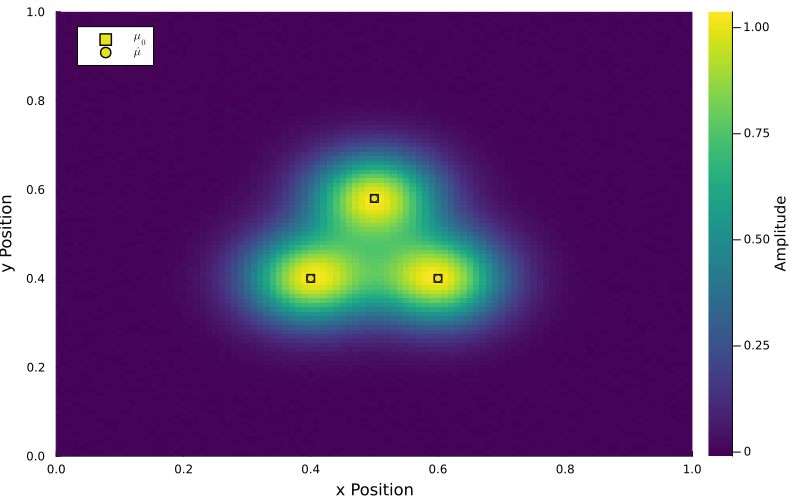

In [9]:
prob = BLASSO(y, ops, domain)

plt_cert_behav = deepcopy(plt_obs)

solve!(prob, :SFW, δ = noise_level, τ = 25, q = 0.3, options = Dict(:maxits => 4))
plot_spikes!(plt_cert_behav, prob.μ, label=L"\hat{μ}", marker=:circle)

 20.294417 seconds (187.31 M allocations: 14.708 GiB, 13.70% gc time, 36.50% compilation time)


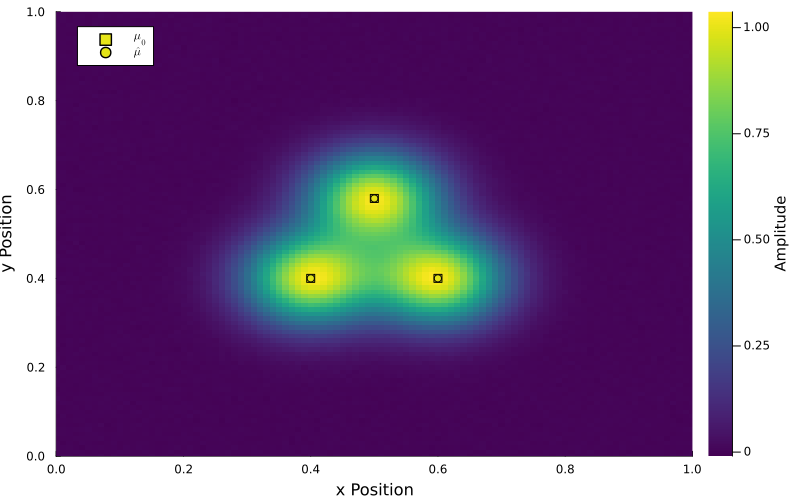

In [10]:
prob = BLASSO(y, ops, domain, 1)
@time solve!(prob)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle)